In [1]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

from fastai.conv_learner import *


/home/katou/anaconda3/envs/GPU/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [3]:
location = 'home'

if(location == 'home'):
    PATH = '/home/katou/Python/GitHubRepo/Data/Kaggle Salt Id/'
elif(location == 'work'):
    PATH = 'C:\\Users\\SCatheline\\Documents\\GitHub repo\\FirstTest\\Kaggle_Challenge_LIVE-master\\data\\'
else:
    print('Unavailable location.')
#train image + mask data
train_mask = pd.read_csv(PATH+'train.csv')
#depth data
depth = pd.read_csv(PATH+'depths.csv')
#training path
train_path = PATH+'train'

#list of files
file_list = list(train_mask['id'].values)
#define our dataset using our class
dataset = TGSSaltDataset(train_path, file_list)

In [4]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

In [5]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [6]:
bs = 64
sz = 128
im_width = sz
im_height = sz
border = 5
im_chan = 3 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth

In [7]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"/images"))[2] if location == 'home' else next(os.walk(train_path+"\\images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float64)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float64)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float64)
M = np.zeros((len(train_ids),), dtype=np.float64)
SQ = np.zeros((len(train_ids),1), dtype=np.float64)   #salt quantity in image
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True) if location == 'home' else load_img(path + '\\images\\' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (sz, sz, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True)) if location == 'home' else img_to_array(load_img(path + '\\masks\\' + id_, grayscale=True))
    mask = resize(mask, (sz, sz, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    #X[n, ..., 1] = x_csum.squeeze()
    X[n, ..., 2] = x_img.squeeze() / 255
    X[n, ..., 1] = x_img.squeeze() / 255
    M[n] = np.mean(x_img.squeeze() / 255)
    y[n] = mask / 255
    SQ[n] = np.mean(y[n])

print('Done!')

MM = np.mean(M)
SS = np.std(M)

Using TensorFlow backend.


Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]/home/katou/anaconda3/envs/GPU/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:15<00:00, 261.59it/s]

Done!


In [8]:
from sklearn.model_selection import train_test_split

#split the data using the coverage of salt in the image
Cov = np.zeros((y.shape[0],),dtype = float)
for i in range(y.shape[0]):
    Cov[i] = int(round(10*np.mean(y[i,:,:,0])))


X_train, X_valid, SQ_train, SQ_valid = train_test_split(X, SQ, test_size=0.15, stratify=Cov, random_state=42)


print(X_train.shape)
print(X_valid.shape)
print(SQ_train.shape )
print(SQ_valid.shape)

(3400, 128, 128, 3)
(600, 128, 128, 3)
(3400, 1)
(600, 1)


In [9]:
print(X_train.dtype)
print(X_valid.dtype)
print(SQ_train.dtype)
print(SQ_valid.dtype)

float64
float64
float64
float64


In [10]:
#plt.hist(SQ_train)

In [11]:
#plt.hist(SQ_valid)

In [12]:
PATH='./'

In [13]:
def ReshapeData(X):
    return X.reshape(X.shape[0],X.shape[1]*X.shape[2]*X.shape[3])

X_train2 = ReshapeData(X_train)
X_valid2 = ReshapeData(X_valid)

print(X_train2.shape)
print(X_valid2.shape)

(3400, 49152)
(600, 49152)


## Compute the statistics of the images


In [14]:
MM = np.mean(M)
SS = np.std(M)
stats = (np.array([MM, MM, MM]), np.array([SS, SS, SS]))

In [15]:
print(stats)

(array([0.47039, 0.47039, 0.47039]), array([0.11278, 0.11278, 0.11278]))


In [16]:
def get_data(sz,bs,stats):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()])
    return ImageClassifierData.from_arrays(PATH, trn = (X_train,SQ_train),val = (X_valid,SQ_valid), tfms=tfms, bs=bs, continuous=True)

In [17]:
#ImageClassifierData.from_arrays??

(array([324.,  43.,  29.,  27.,  34.,  32.,  29.,  18.,  30.,  34.]),
 array([0.     , 0.09963, 0.19927, 0.2989 , 0.39853, 0.49817, 0.5978 , 0.69744, 0.79707, 0.8967 , 0.99634]),
 <a list of 10 Patch objects>)

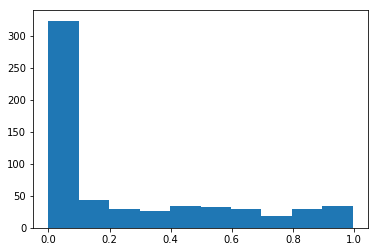

In [18]:
plt.hist(SQ_valid)

In [19]:
data = get_data(sz,bs,stats)

In [20]:
arch=resnet34   #resnetx50
#arch=resnext50


In [21]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [22]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [23]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = self.drop(l3(l2(l(x))))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return torch.sigmoid(self.out(x))  #F.log_softmax(self.out(x), dim=-1)

In [24]:
def mse(preds, targs):
    loss = nn.MSELoss()
    return loss(preds,targs)

In [25]:
#learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 1, 0.5), data, metrics = [mse])

In [26]:
learn = ConvLearner.pretrained(arch, data)

In [27]:
learn.opt_fn=optim.Adam

In [28]:
#learn.crit=nn.MSELoss()

In [29]:
#ConvNet = ConvnetBuilder(arch, 1, is_multi = False, is_reg = True) #, ps = 0.5)

In [30]:
#learn = ConvLearner.from_model_data(ConvNet.model, data)

In [31]:
#learn.summary()

In [32]:
lrf=learn.lr_find()

 87%|████████▋ | 47/54 [00:12<00:01,  3.88it/s, loss=2.96] 

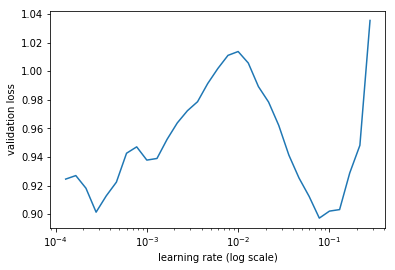

In [33]:
learn.sched.plot()

In [356]:
learn.fit(5e-4, 1,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss                             
    0      0.895217   0.457018  
    1      0.752066   0.341346                             
    2      0.685095   0.293329                             


[0.2933285689353943]

In [357]:
learn.fit(5e-4, 2,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss                             
    0      0.639246   0.377609  
    1      0.578043   0.257986                             
    2      0.547751   0.228478                             
    3      0.511702   0.237633                             
    4      0.46248    0.193538                             
    5      0.424632   0.181125                             


[0.18112484594186148]

In [358]:
learn.fit(5e-4, 3,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss                             
    0      0.402007   0.212945  
    1      0.36059    0.167142                             
    2      0.338044   0.153391                             
    3      0.317015   0.157562                             
    4      0.281181   0.1484                               
    5      0.259943   0.143261                             
    6      0.243809   0.146513                             
    7      0.220318   0.127183                             
    8      0.202194   0.126899                             


[0.12689905802408855]

In [359]:
learn.fit(5e-4, 3,wds = 1e-4,cycle_len = 2,cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.20038    0.138603  
    1      0.183041   0.125305                             
    2      0.174565   0.136347                             
    3      0.160273   0.116931                             
    4      0.15186    0.114611                             
    5      0.143448   0.114013                             
    6      0.141807   0.113284                             
    7      0.140289   0.116959                             
    8      0.13072    0.115332                             
    9      0.126915   0.112223                             
    10     0.124914   0.111465                             
    11     0.119148   0.110315                             
    12     0.119247   0.110192                             
    13     0.116497   0.110403                             


[0.11040250231822332]

In [362]:
learn.fit(1e-4, 2,wds = 1e-4,cycle_len = 2,cycle_mult=2)

epoch      trn_loss   val_loss                             
    0      0.118271   0.11164   
    1      0.118398   0.110992                             
    2      0.118527   0.109542                             
    3      0.113837   0.111524                             
    4      0.115442   0.108698                             
    5      0.115998   0.110236                             


[0.11023649821678798]

In [363]:
learn.save('salt_pred_resnext50')

In [364]:
learn.load('salt_pred_resnext50')

In [365]:
learn.unfreeze()

In [366]:
lr = 1e-4

In [367]:
lrs=np.array([lr/100,lr/10,lr])

In [368]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

  0%|          | 0/54 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory

In [318]:
learn.save('salt_pred_resnet')

In [319]:
learn.load('salt_pred_resnet')

In [325]:
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      0.08337    0.072479  
    1      0.080102   0.0718                                
    2      0.076982   0.065531                              
    3      0.07497    0.068251                              
    4      0.072603   0.067761                              
    5      0.067197   0.06209                               
    6      0.069906   0.06741                               
    7      0.067537   0.063626                              
    8      0.066419   0.065437                              
    9      0.062444   0.060351                              
    10     0.062487   0.060551                              
    11     0.05899    0.056277                              
    12     0.05506    0.055075                              
    13     0.056575   0.056416                              
    14     0.054727   0.054729                              


[0.05472945397098859]

In [326]:
learn.save('salt_pred_resnet')

In [327]:
learn.load('salt_pred_resnet')

In [333]:
lr = 2e-4

In [334]:
lrs=np.array([lr/100,lr/10,lr])

In [335]:
learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                              
    0      0.054558   0.055993  
    1      0.052937   0.054139                              
    2      0.050317   0.058507                              
    3      0.049659   0.051985                              
    4      0.05341    0.058298                              
    5      0.048811   0.054681                              
    6      0.048174   0.05536                               
    7      0.050429   0.056971                              
    8      0.051881   0.054951                              
    9      0.049748   0.055025                              
    10     0.044961   0.054235                              
    11     0.047249   0.055664                              
    12     0.047698   0.057777                              
    13     0.047942   0.053278                              
    14     0.049242   0.056666                              


[0.056666284402211504]

In [336]:
lrf=learn.lr_find()

 72%|███████▏  | 39/54 [00:15<00:05,  2.50it/s, loss=0.181] 

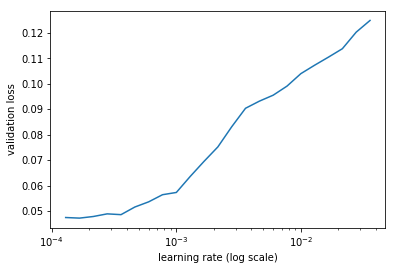

In [337]:
learn.sched.plot()

In [ ]:
wds = 1e-5,

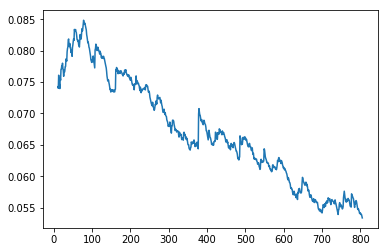

In [328]:
learn.sched.plot_loss()

In [329]:
log_preds = learn.predict()

(array([316.,  45.,  31.,  40.,  43.,  36.,  26.,  33.,  21.,   9.]),
 array([-0.01225,  0.09316,  0.19857,  0.30398,  0.40939,  0.51479,  0.6202 ,  0.72561,  0.83102,  0.93643,
         1.04184], dtype=float32),
 <a list of 10 Patch objects>)

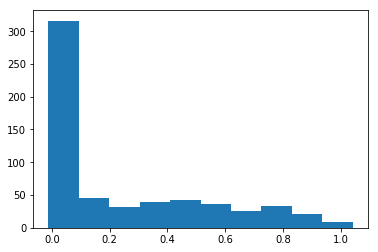

In [330]:
plt.hist(log_preds)

(array([324.,  43.,  29.,  27.,  34.,  32.,  29.,  18.,  30.,  34.]),
 array([0.     , 0.09963, 0.19927, 0.2989 , 0.39853, 0.49817, 0.5978 , 0.69744, 0.79707, 0.8967 , 0.99634]),
 <a list of 10 Patch objects>)

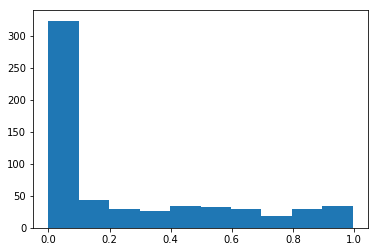

In [331]:
plt.hist(SQ_valid)

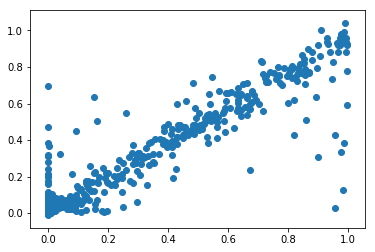

In [332]:
plt.scatter(SQ_valid,log_preds)

In [163]:
learn.save('salt_pred_resnet_50')

In [ ]:
learn.load('salt_pred_resnet_50')

In [164]:
learn.fit(1e-3, 1,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss   mse                        
    0      0.092719   0.060985   1.027248  
    1      0.074279   0.061397   1.081387                   
    2      0.05813    0.075145   1.127753                   


[0.07514463985959689, 1.1277531210581462]

In [165]:
learn.save('salt_pred_50_2')

In [174]:
learn.load('salt_pred_50_2')

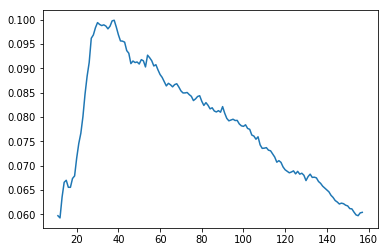

In [167]:
learn.sched.plot_loss()

In [175]:
learn.fit(5e-4, 3,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss   mse                        
    0      0.05552    0.05342    1.064527  
    1      0.053113   0.076527   1.144522                   
    2      0.049958   0.04816    1.008766                   
    3      0.052477   0.035856   1.026242                   
    4      0.048444   0.046696   1.054536                   
    5      0.043958   0.043898   1.046118                   
    6      0.046557   0.044128   1.008263                   
    7      0.044177   0.044178   1.060512                   
    8      0.040447   0.058307   1.09836                    


[0.05830724492669106, 1.098360252380371]

In [176]:
learn.save('salt_pred_50_2')

In [177]:
learn.load('salt_pred_50_2')

In [183]:
learn.fit(5e-4, 3,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss   mse                        
    0      0.048429   0.04487    1.070254  
    1      0.043704   0.051944   1.072637                   
    2      0.040003   0.057281   1.093531                   
    3      0.040968   0.034937   1.021396                   
    4      0.040097   0.039239   1.054606                   
    5      0.036156   0.04531    1.067863                   
    6      0.038268   0.034393   1.01332                    
    7      0.039449   0.041014   1.038407                   
    8      0.035447   0.045864   1.066862                   


[0.04586405277252197, 1.06686203956604]

In [184]:
learn.save('salt_pred_50_2')

In [281]:
learn.load('salt_pred_50_2')

In [282]:
learn.fit(1e-4, 2,wds = 1e-5,cycle_len = 3)

epoch      trn_loss   val_loss   mse                        
    0      0.033811   0.045155   0.045155  
    1      0.033267   0.040988   0.040988                   
    2      0.032664   0.037054   0.037054                   
    3      0.030852   0.04833    0.04833                    
    4      0.031539   0.062105   0.062105                   
    5      0.030018   0.053597   0.053597                   


[0.05359693189462026, 0.05359693189462026]

In [283]:
learn.fit(2e-5, 2,wds = 1e-5,cycle_len = 3)

epoch      trn_loss   val_loss   mse                        
    0      0.029664   0.047476   0.047476  
    1      0.029222   0.05337    0.05337                    
    2      0.029284   0.041367   0.041367                   
    3      0.028741   0.043527   0.043527                   
    4      0.028867   0.052393   0.052393                   
    5      0.029055   0.049557   0.049557                   


[0.04955705379446348, 0.04955705379446348]

In [188]:
py,ay = learn.predict_with_targs()

(array([ 55.,  75., 116.,  97.,  84.,  59.,  38.,  33.,  28.,  15.]),
 array([0.00583, 0.07959, 0.15335, 0.2271 , 0.30086, 0.37461, 0.44837, 0.52212, 0.59588, 0.66963, 0.74339],
       dtype=float32),
 <a list of 10 Patch objects>)

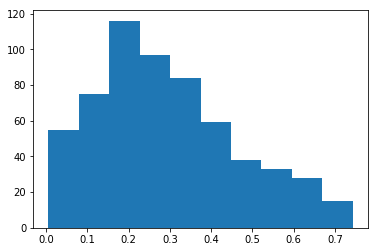

In [190]:
plt.hist(py)

In [185]:
lrf=learn.lr_find()

 89%|████████▉ | 48/54 [00:19<00:02,  2.44it/s, loss=0.109] 

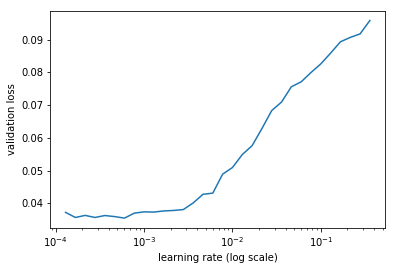

In [186]:
learn.sched.plot()

In [111]:
learn.fit(1e-3, 2,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss   mse                       
    0      0.305624   0.169228   1.014001  
    1      0.197443   0.13551    0.916337                  
    2      0.164875   0.18214    0.943415                  
    3      0.171098   0.120542   0.944977                  
    4      0.139321   0.113153   0.900777                  
    5      0.115096   0.148433   0.859236                  


[0.14843339423338572, 0.8592364533742269]

 48%|████▊     | 26/54 [00:10<00:11,  2.43it/s, loss=0.19]  

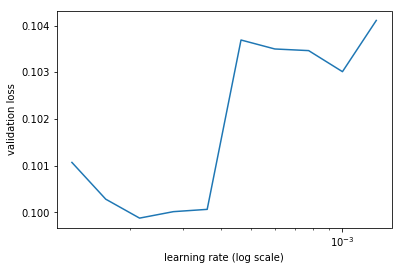

In [112]:
lrf=learn.lr_find()
learn.sched.plot()

In [113]:
learn.fit(2e-4, 2,wds = 1e-4,cycle_len = 3)

epoch      trn_loss   val_loss   mse                       
    0      0.112262   0.118088   0.927928  
    1      0.0993     0.094873   0.935797                  
    2      0.090849   0.111478   0.914798                   
    3      0.096427   0.149067   0.854146                   
    4      0.09079    0.113398   0.884238                   
    5      0.088417   0.102311   0.900193                   


[0.10231087813774745, 0.9001932342847189]

In [114]:
learn.fit(1e-4, 2,wds = 1e-5,cycle_len = 3)

epoch      trn_loss   val_loss   mse                        
    0      0.090774   0.147305   0.854359  
    1      0.085298   0.121884   0.870614                   
    2      0.084777   0.105721   0.888572                   
    3      0.09144    0.080078   0.921688                   
    4      0.084641   0.123071   0.878027                   
    5      0.081789   0.126679   0.862276                   


[0.12667893886566162, 0.8622760200500488]

In [179]:
py,ay = learn.predict_with_targs()

(array([324.,  43.,  29.,  27.,  34.,  32.,  29.,  18.,  30.,  34.]),
 array([0.     , 0.09963, 0.19927, 0.2989 , 0.39853, 0.49817, 0.5978 , 0.69744, 0.79707, 0.8967 , 0.99634],
       dtype=float32),
 <a list of 10 Patch objects>)

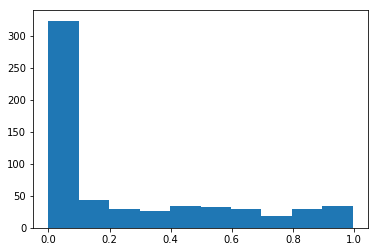

In [180]:
plt.hist(ay)

(array([76., 40., 70., 95., 79., 63., 55., 44., 47., 31.]),
 array([0.00008, 0.08305, 0.16602, 0.24899, 0.33197, 0.41494, 0.49791, 0.58089, 0.66386, 0.74683, 0.82981],
       dtype=float32),
 <a list of 10 Patch objects>)

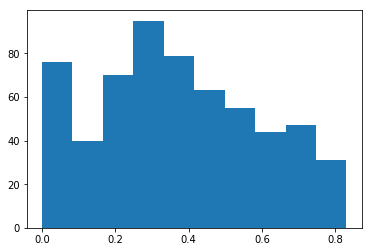

In [181]:
plt.hist(py)

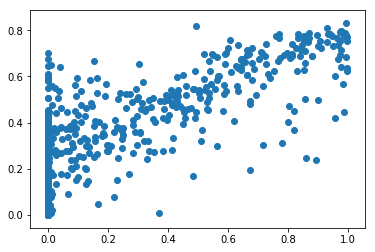

In [182]:
plt.scatter(ay, py)

In [90]:
learn.predict_with_targs??

In [67]:
learn.fit(1e-3, 3,wds = 1e-4,cycle_len = 2)

epoch      trn_loss   val_loss   mse                       
    0      0.348349   0.141243   0.932346  
    1      0.269827   0.106006   0.967985                  
    2      0.270919   0.127963   0.94363                   
    3      0.228392   0.115482   0.936873                  
    4      0.248923   0.250179   0.869882                  
    5      0.21392    0.126673   0.928781                  


[0.1266730566819509, 0.9287806590398152]

In [68]:
learn.fit(1e-4, 2,wds = 1e-4,cycle_len = 2)

epoch      trn_loss   val_loss   mse                       
    0      0.172668   0.118784   0.924003  
    1      0.167234   0.109533   0.93809                   
    2      0.173864   0.142905   0.889727                  
    3      0.168768   0.119507   0.946805                  


[0.11950731128454209, 0.9468053595225017]

 54%|█████▎    | 29/54 [00:11<00:10,  2.44it/s, loss=0.588]

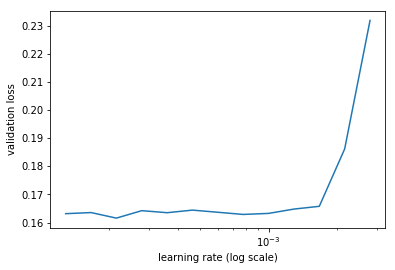

In [69]:
lrf=learn.lr_find()
learn.sched.plot()

In [70]:
learn.fit(1e-5, 2,wds = 1e-4,cycle_len = 2)

epoch      trn_loss   val_loss   mse                       
    0      0.156513   0.115753   0.927573  
    1      0.156893   0.271179   0.871607                  
    2      0.165841   0.115047   0.924397                  
    3      0.16411    0.119433   0.910514                  


[0.11943310578664144, 0.9105136251449585]

epoch      trn_loss   val_loss   mse                        
    0      0.07024    0.071291   0.976395  
    1      0.058863   0.096817   0.897897                   
    2      0.063323   0.068497   1.019773                   
    3      0.056901   0.084793   0.900775                   


[0.08479318251212438, 0.900774868329366]

In [54]:
learn.fit(1e-3, 1,wds = 1e-4,cycle_len = 4)

epoch      trn_loss   val_loss   mse                        
    0      0.058307   0.083261   0.895734  
    1      0.055187   0.062879   0.962278                   
    2      0.0511     0.080261   0.898845                   
    3      0.048403   0.065438   0.95239                    


[0.06543819343050321, 0.9523895494143169]

In [85]:
learn.predict??

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
print(results)
pred = model.predict({'img': X_valid, 'feat': X_feat_valid},verbose = 1)

print(pred.shape)
print(y_valid.shape)

In [ ]:

a=pred.squeeze(axis = 3)
print(y_valid.shape)


In [ ]:
i=np.random.randint(0, y_valid.shape[0])

a= y_valid[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
b= pred[i,:,:].reshape((y_valid.shape[1],y_valid.shape[2]))
c = 255*X_valid[i,:,:,1].reshape((X_valid.shape[1],X_valid.shape[2]))

plot2x2Array(a, np.round(b))
plot2x2Array(a,c)